In [1]:
import time
import colorsys
from sys import path
import pandas as pd
from pandas.core.common import flatten
import matplotlib.pyplot as plt
from datetime import datetime

path.append('../')
from utils.find_sessions_by_period import find_sessions_by_period
from utils.find_user_sessions_by_period import find_user_sessions_by_period
from utils.find_user_by_id import find_user_by_id

In [ ]:
# формат докстрингов

'''
Функция ...

Параметры
---------

Возвращаемое значение
---------------------

Автор
-----

'''


# Какие должны быть графики  

## Реализовано

### По ТЗ
1. Сумма времени, проведенного в вк по часам **(Столбчатая диаграмма)**
    * Сколько времени за день в онлайне был отдельный человек (с погрешностью на основании количества промежутков записи - *провел в сети 1:01 или 1:05*)
1. Распределение длительности сессий для каждого человека **(Диаграмма Бокса-Уискера)**
1. Гистограмма длительности сессий **(Гистограмма)**
1. Длительность сессии в зависимости от времени её начала **(Диаграмма рассеяния)**

### Просто так
1. Онлайн для отдельного человека в течение дня **(Точки)**
1. Количество человек в онлайне по минутам **(Линейный график)**
    * ToDo: Возможность наложения двух графиков для сравнения
    * ToDo: Уплавнение графика (скользящее среднее либо более длинные выборки)


## Не реализовано

### Просто
1. Суммарное время в сети (это модно, типа считать сколько миллиордов часов посмотрели пользователи ютуба) *(просто число)*
1. Медианная и средняя сессия в течение дня *(просто число)*
1. Средняя и медианная длительность сессии по часам **(столбчатая диаграмма для среднего и линия для медианы)**
1. Самая часто используемая платформа *(строка)*
1. Сравнение среднего времени (одной сессии) по платформам **(столбчатая диаграмма)**

### Сложно
1. Время отхода ко сну
1. Время подъема
1. Средняя продолжительность сна
1. Корреляция времени отхода ко сну с рейтингом студента
1. Время отхода ко сну в зависимости от пола студента

# Обработка времени

In [8]:
# https://i-leon.ru/tools/time
def to_timestamp(day=1, month=1, year=2022, hour=0, minute=0, second=0, epoch=0):
    '''
    Функция преобразовывает набор аргументов (день, месяц, год, час, минута, секунда)
    или число формата Unix timestamp в тип pandas.Timestamp

    Параметры
    ---------
    day : int
    month : int
    year : int
    hour : int
    minute : int
    second : int
    epoch : int

    Возвращаемое значение
    ---------------------
    t : pandas.Timestamp

    Автор
    -----
    Иван Чеканов
    '''
    if epoch:
        t = pd.to_datetime(epoch, unit="s")
    else:
        s = f"{hour}:{minute}:{second}, {day}.{month}.{year}"
        t = time.strptime(s, "%H:%M:%S, %d.%m.%Y")
        t = time.mktime(t)
        t = pd.to_datetime(t, unit="s")
    t = t.tz_localize("UTC").tz_convert("Europe/Moscow")
    return t


In [3]:
def to_unix(timestamp):
    '''
    Функция преобразовывает pandas.Timestamp в число формата Unix timestamp

    Параметры
    ---------
    timestamp : pandas.Timestamp
        timestamp в формате pandas 

    Возвращаемое значение
    ---------------------
    t : int
        число формата Unix timestamp

    Автор
    -----
    Иван Чеканов
    '''
    base = pd.Timestamp("1970-01-01")
    base = base.tz_localize("UTC").tz_convert("Europe/Moscow")
    t = (timestamp - base) // pd.Timedelta('1s')
    return t


Проверка

In [28]:
print(to_timestamp(epoch=1640457061))
print(to_unix(to_timestamp(epoch=1640457061)))


2021-12-25 21:31:01+03:00
1640457061


# Онлайн-активность человека (точечный график)

In [4]:
# https://question-it.com/questions/1862232/kak-raskrasit-tochki-dannyh-na-osnove-nekotoryh-pravil-v-matplotlib
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html

def graph_daily_activity(user, start, end):
    '''
    Функция генерирует график активности пользователя с цветовой маркировкой длительности непрерывной сессии за указанный период.

    Параметры
    ---------
    user : int
        id пользователя, о котором требуется получить информацию
    start : pandas.Timestamp
        начало временного промежутка
    end : pandas.Timestamp
        конец временного промежутка

    Возвращаемое значение
    ---------------------
    fig : matplotlib.pyplot.figure
        объект figure с одним графиком и необходимыми подписями к нему

    Автор
    -----
    Иван Чеканов
    '''
    data = find_user_sessions_by_period(user, start, end)
    user_name = find_user_by_id(user)[0].name
    # список списков, состоящих из timestamp с шагом 5 секунд и соответствющих периодам активности пользователя
    period = [pd.date_range(session[0].session_start,
                            session[0].session_end, freq='5S') for session in data]
    # вспомогательный список, в котором хранятся цвета для заливки точек
    color = []
    # коэффициент скорости смены зеленого на красный
    KR = 0.12
    for slot in period:
        h = 120/360
        l = 1
        for _ in range(len(slot)):
            if h-0.015*KR > 0:
                h -= 0.01*KR
                l -= 0.002*KR
            elif l-0.01*KR > 0.5:
                l -= 0.01*KR
            color += [colorsys.hsv_to_rgb(h, 1, l)]
    # преобразовываем двумерный массив в одномерный
    period = list(flatten(period))
    # список точек, которые будут окрашены в цвета
    activity = [1]*len(period)
    # временная шкала, вспомогательный список
    time_tick = pd.date_range(start, end, freq="1H")
    # фактически отображаемые на графике подписи оси Х
    time_tick_labels = [i.strftime("%H:%M") for i in time_tick]
    fig, plt1 = plt.subplots()
    fig.set_dpi(100)
    fig.set_facecolor('w')
    fig.set_size_inches((17, 1.35))
    plt1.set_title(
        f'Активность пользователя {user_name} в период {start.strftime("%d.%m.%Y %H:%M")} — {end.strftime("%d.%m.%Y %H:%M")}')
    plt1.scatter(period, activity, marker='o', c=color)
    plt1.set_xlim((start, end))
    plt1.set_xticks(time_tick)
    plt1.set_xticklabels(time_tick_labels)
    plt1.set_yticks([])
    plt1.set_ylim((0.75, 1.25))
    plt1.set_xlabel("Время")
    fig.tight_layout()
    return fig


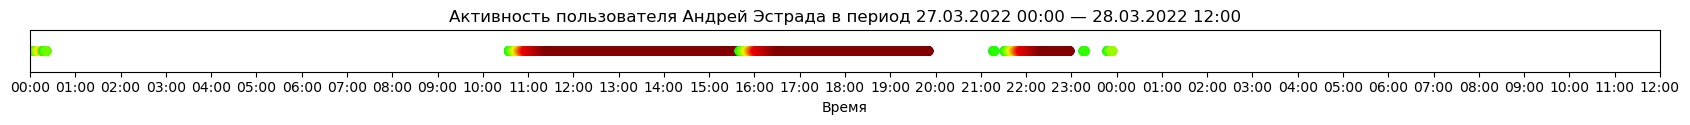

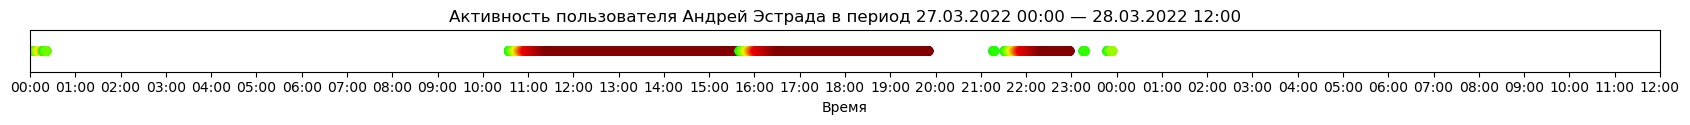

In [12]:
graph_daily_activity(195, datetime(2022, 3, 27), datetime(2022, 3, 28, 12))


# Количество человек в онлайне (линейный график)

In [26]:
def graph_online_counter(start, end):
    data = find_sessions_by_period(start, end)
    time_tick = list(pd.date_range(start, end, freq='5S'))
    counter = {t: 0 for t in time_tick}
    for slot in data:
        tstamps = pd.date_range(max(slot[0].session_start, start), min(
            slot[0].session_end, end), freq='5S')
        for i in tstamps:
            counter[i] += 1
    counter = list(counter.values())
    fig, plt1 = plt.subplots()
    fig.set_dpi(100)
    fig.set_facecolor('w')
    fig.set_size_inches((17, 7))
    plt1.set_title(
        f'Активность пользователей в период {start.strftime("%d.%m.%Y %H:%M")} — {end.strftime("%d.%m.%Y %H:%M")}')
    plt1.plot(time_tick, counter)
    plt1.set_xlim((start, end))
    time_tick = pd.date_range(start, end, freq='1H')
    time_tick_labels = [i.strftime('%H:%M') for i in time_tick]
    plt1.set_xticks(time_tick)
    plt1.set_xticklabels(time_tick_labels)
    plt1.set_xlabel('Время')
    plt1.set_ylabel('Количество пользователей в сети')
    fig.tight_layout()
    return fig
    

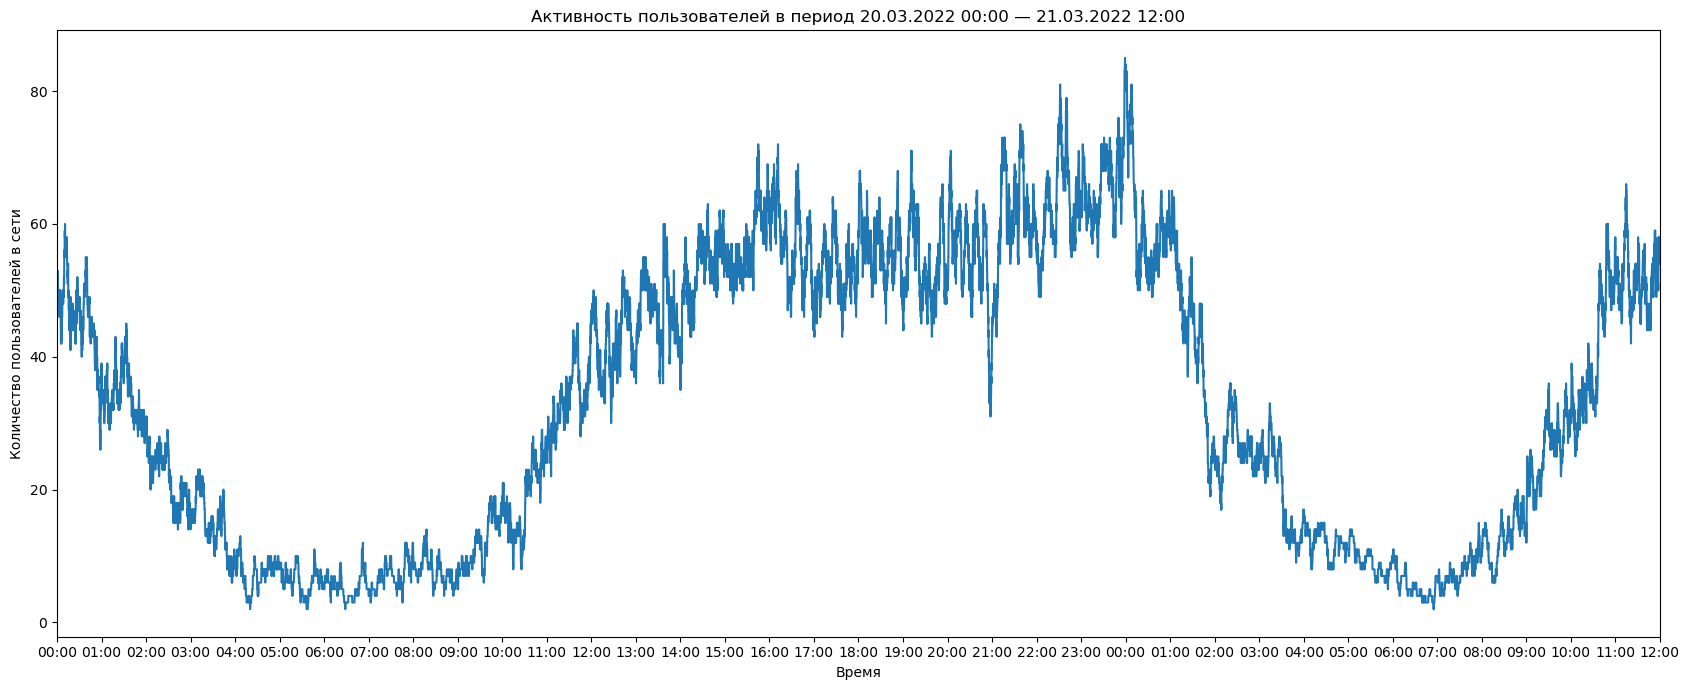

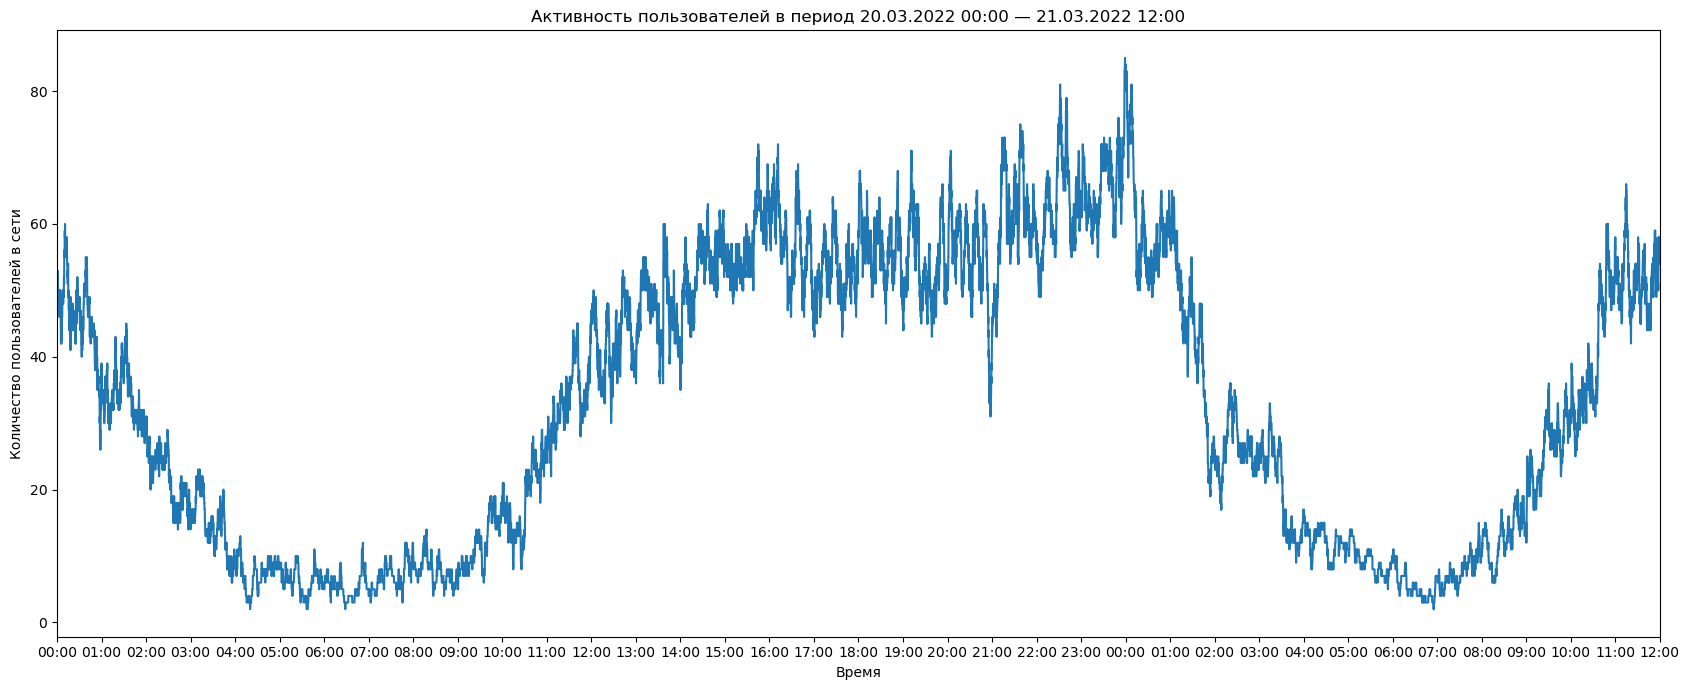

In [27]:
graph_online_counter(datetime(2022, 3, 20), datetime(2022, 3, 21, 12))
